## Adrija Paul 

1.What percentage of users opened the email and what percentage clicked on the link within the email?

2.The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?
By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

3.Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the data
email_table = pd.read_csv('email_table.csv')
email_opened = pd.read_csv('email_opened_table.csv')
link_clicked = pd.read_csv('link_clicked_table.csv')


In [3]:
# Question 1: Open and Click Rates
def calculate_rates(email_table, email_opened, link_clicked):
    total_emails = len(email_table)
    opened_count = len(email_opened)
    clicked_count = len(link_clicked)
    
    open_rate = (opened_count / total_emails) * 100
    click_rate = (clicked_count / total_emails) * 100
    
    print(f"1. Email Open Rate: {open_rate:.2f}%")
    print(f"   Email Click Rate: {click_rate:.2f}%")
    print(f"   Click-to-Open Rate: {(clicked_count/opened_count)*100:.2f}%" if opened_count > 0 else "No opens")
    
    return open_rate, click_rate

In [6]:
# Question 2: Build Optimization Model
def build_model(email_table, email_opened, link_clicked):
    # Prepare data
    df = email_table.copy()
    df['opened'] = df['email_id'].isin(email_opened['email_id']).astype(int)
    df['clicked'] = df['email_id'].isin(link_clicked['email_id']).astype(int)
    
    # Feature engineering
    df['email_text'] = df['email_text'].map({'long text': 1, 'short text': 0})
    df['email_version'] = df['email_version'].map({'personalized': 1, 'generic': 0})
    df['hour'] = df['hour'].astype(int)
    df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday']).astype(int)
    
    country_encoder = LabelEncoder()
    df['user_country_encoded'] = country_encoder.fit_transform(df['user_country'])

    # Features and target
    features = ['email_text', 'email_version', 'hour', 'is_weekend', 
                'user_country_encoded', 'user_past_purchases']
    X = df[features]
    y = df['clicked']
    
     #Train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Feature importance
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n2. Model Feature Importance:")
    print(importance)
    
    return model, df


In [7]:
 # Question 3: Estimate CTR Improvement
def estimate_improvement(model, df):
    features = ['email_text', 'email_version', 'hour', 'is_weekend', 
                'user_country_encoded', 'user_past_purchases']
    df['predicted_prob'] = model.predict_proba(df[features])[:, 1]
    
    original_ctr = df['clicked'].mean()
    top_50_ctr = df.nlargest(int(len(df)*0.5), 'predicted_prob')['clicked'].mean()
    top_30_ctr = df.nlargest(int(len(df)*0.3), 'predicted_prob')['clicked'].mean()
    
    print(f"\n3. Original CTR: {original_ctr:.4f}")
    print(f"   Top 50% Predicted CTR: {top_50_ctr:.4f} ({(top_50_ctr - original_ctr)/original_ctr:.1%} improvement)")
    print(f"   Top 30% Predicted CTR: {top_30_ctr:.4f} ({(top_30_ctr - original_ctr)/original_ctr:.1%} improvement)")
     # A/B testing suggestion
    print("\n   A/B Testing Approach:")
    print("   - Split users randomly into two groups")
    print("   - Control group: Send emails randomly (current approach)")
    print("   - Test group: Send only to top 30% predicted by model")
    print("   - Compare CTR between groups after 1-2 weeks")


ANSWERS TO THE QUESTIONS:

1. Email Open Rate: 10.35%
   Email Click Rate: 2.12%
   Click-to-Open Rate: 20.48%

2. Model Feature Importance:
                feature  importance
2                  hour    0.462362
5   user_past_purchases    0.417198
4  user_country_encoded    0.066788
3            is_weekend    0.028080
1         email_version    0.025571
0            email_text    0.000000

3. Original CTR: 0.0212
   Top 50% Predicted CTR: 0.0377 (78.0% improvement)
   Top 30% Predicted CTR: 0.0534 (151.8% improvement)

   A/B Testing Approach:
   - Split users randomly into two groups
   - Control group: Send emails randomly (current approach)
   - Test group: Send only to top 30% predicted by model
   - Compare CTR between groups after 1-2 weeks

4. Segment Analysis Results:

   By Email Characteristics:
   Text Length:
Series([], Name: clicked, dtype: float64)

   Personalization:
email_version
generic         0.015137
personalized    0.027294
Name: clicked, dtype: float64

   By Ti

C:\Users\ADRIJA\AppData\Local\Temp\ipykernel_23672\3808478951.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(pd.qcut(df['user_past_purchases'], 5))['clicked'].mean())


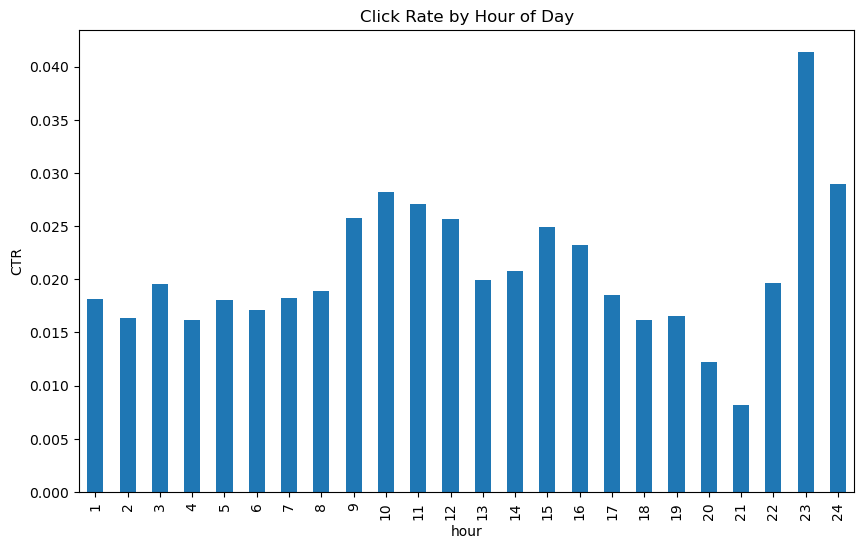

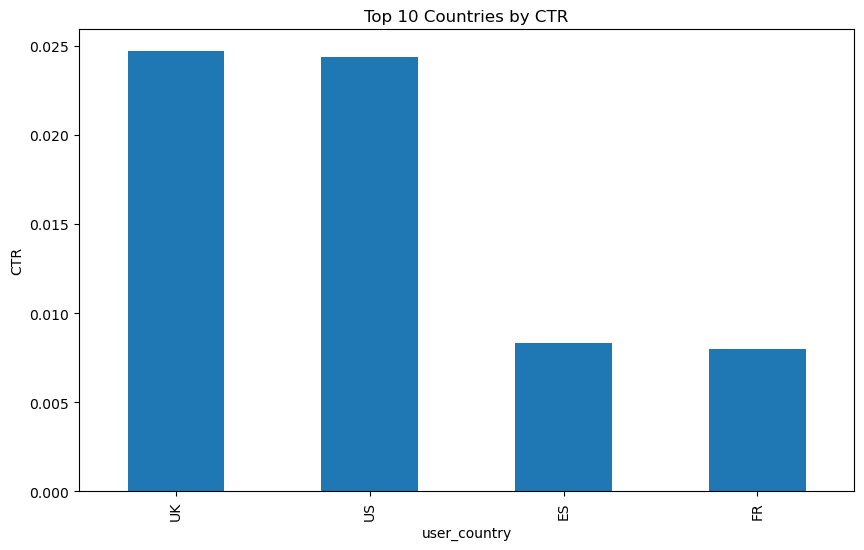

In [9]:
# Question 4: Segment Analysis
def analyze_segments(df):
    print("\n4. Segment Analysis Results:")
    
    # Email characteristics
    print("\n   By Email Characteristics:")
    print("   Text Length:")
    print(df.groupby('email_text')['clicked'].mean().rename({0: 'short', 1: 'long'}))
    print("\n   Personalization:")
    print(df.groupby('email_version')['clicked'].mean().rename({0: 'generic', 1: 'personalized'}))
    
    # Timing
    print("\n   By Timing:")
    print("   Best Hours:")
    print(df.groupby('hour')['clicked'].mean().sort_values(ascending=False).head(5))
    print("\n   Weekend vs Weekday:")
    print(df.groupby('is_weekend')['clicked'].mean().rename({0: 'weekday', 1: 'weekend'}))
    
    # User attributes
    print("\n   By User Attributes:")
    print("   Top Countries:")
    print(df.groupby('user_country')['clicked'].mean().sort_values(ascending=False).head(5))
    print("\n   By Past Purchases:")
    print(df.groupby(pd.qcut(df['user_past_purchases'], 5))['clicked'].mean())
    
    # Visualizations
    plt.figure(figsize=(10, 6))
    df.groupby('hour')['clicked'].mean().plot(kind='bar')
    plt.title('Click Rate by Hour of Day')
    plt.ylabel('CTR')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    df.groupby('user_country')['clicked'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
    plt.title('Top 10 Countries by CTR')
    plt.ylabel('CTR')
    plt.show()

# Execute all analyses
print("ANSWERS TO THE QUESTIONS:\n")
open_rate, click_rate = calculate_rates(email_table, email_opened, link_clicked)
model, df = build_model(email_table, email_opened, link_clicked)
estimate_improvement(model, df)
analyze_segments(df)    